In [66]:
import xmitgcm 
import numpy as np
from os.path import expanduser,join,isdir
import sys
import xarray as xr
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
import ecco_v4_py as ecco
import matplotlib.cm as cm
from ecco_v4_py import get_llc_grid as get_llc_grid
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py.ecco_access as ea
from matplotlib import pyplot as plt
import os
import warnings
import cmocean
warnings.filterwarnings("ignore")

In [67]:
data_dir = "/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5/run/"
data_dir_tides = "/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run/"

In [69]:
ds_eta = xmitgcm.open_mdsdataset(data_dir+"diags/ETAN_mon_mean", grid_dir=data_dir, iters='all', prefix="ETAN_mon_mean", geometry="llc")

In [80]:
ds_eta_tides = xmitgcm.open_mdsdataset(data_dir_tides+"diags/", grid_dir=data_dir_tides, iters='all', prefix="ETAN_snapD", geometry="llc")

In [70]:
variables = ["UVEL", "VVEL", "THETA", "SALT"]

datasets = []
for var in variables:
    path = os.path.join(data_dir+"diags/", f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds = xmitgcm.open_mdsdataset(path, grid_dir=data_dir, iters='all', prefix=prefix, geometry="llc")
    datasets.append(ds)

ds = xr.merge(datasets)

datasets_tides = []
for var in variables:
    path = os.path.join(data_dir_tides+"diags/", f"{var}_mon_mean/")
    prefix = f"{var}_mon_mean"
    ds_tides = xmitgcm.open_mdsdataset(path, grid_dir=data_dir_tides, iters='all', prefix=prefix, geometry="llc")
    datasets_tides.append(ds_tides)

ds_tides = xr.merge(datasets_tides)

In [57]:
# define some useful colormaps where NaNs are black
colMap = cm.RdBu_r
colMap.set_bad(color='black')

jet_colMap_k = cm.jet
jet_colMap_k.set_bad(color='black')

jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='white')

In [58]:
ds = ds.rename({"face": "tile"})
ds_tides = ds_tides.rename({"face": "tile"})

In [59]:
xfld_tides = ds_tides.UVEL.isel(time=0).compute()
yfld_tides = ds_tides.VVEL.isel(time=0).compute()

# Compute the zonal and meridional vector components of oceTAUX and oceTAUY
oceU_tides, oceV_tides  = ecco.vector_calc.UEVNfromUXVY(xfld_tides, yfld_tides, ds_tides)

In [6]:
xfld = ds.UVEL.isel(time=0).compute()
yfld = ds.VVEL.isel(time=0).compute()

# Compute the zonal and meridional vector components of oceTAUX and oceTAUY
oceU, oceV  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ds)

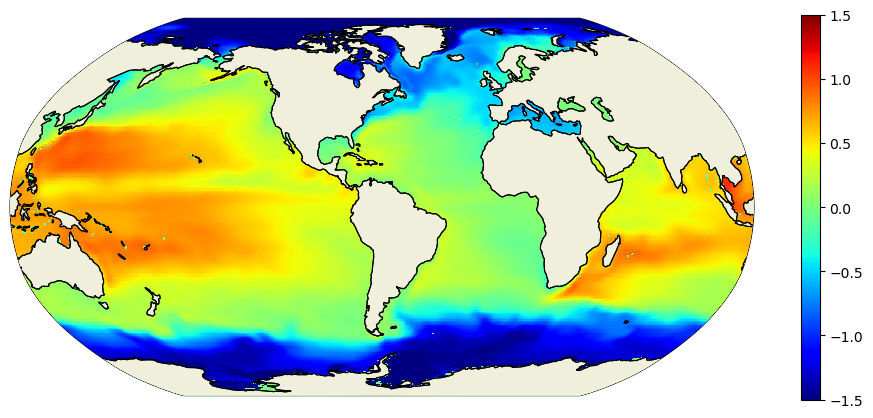

In [75]:
plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ds.XC, ds.YC, ds_eta.ETAN.isel(time=0), 
                                  cmap=jet_colMap_w,
                                  show_colorbar=True, user_lon_0=-66, 
                                  cmin=-1.5,
                                  cmax=1.5)

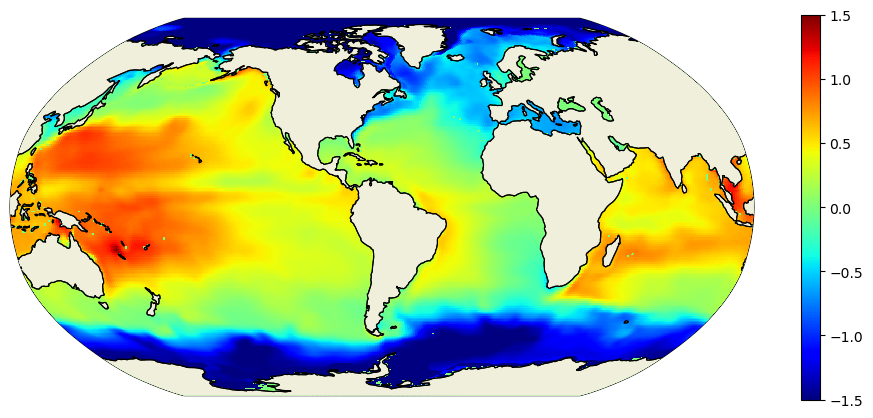

In [116]:
plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ds_tides.XC, ds_tides.YC, ds_eta_tides.ETAN.isel(time=200), 
                                  cmap=jet_colMap_w,
                                  show_colorbar=True, user_lon_0=-66, 
                                  cmin=-1.5,
                                  cmax=1.5)

In [37]:
mask = (oceU.isel(k=0) == 0)
ocean_masked = np.ma.masked_where(mask, ds.ETAN.isel(time=0))
land_masked = np.ma.masked_where(~mask, ds.ETAN.isel(time=0))

In [38]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
ds_lat_lon =\
        ecco.resample_to_latlon(ds.XC, \
                                ds.YC, \
                                ocean_masked,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.nan, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

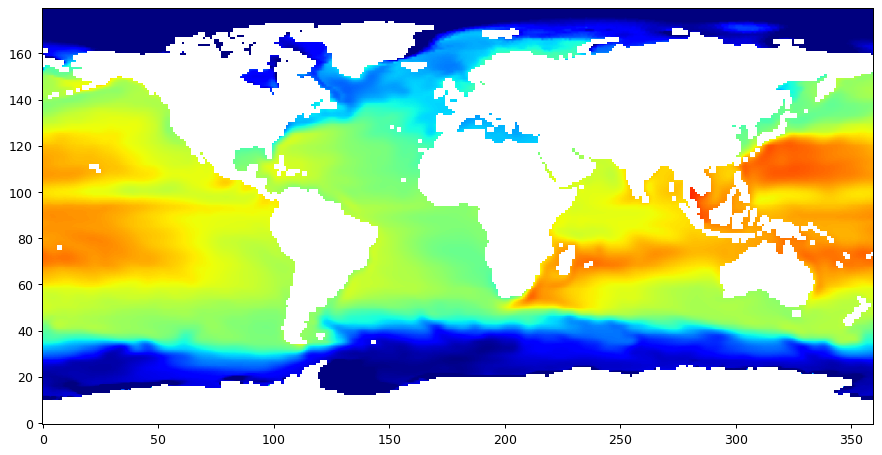

In [39]:
plt.figure(figsize=(12,6), dpi= 90)
plt.imshow(ds_lat_lon,origin='lower', cmap='jet', vmin = -1.5, vmax=1.5)

(<Figure size 900x789 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

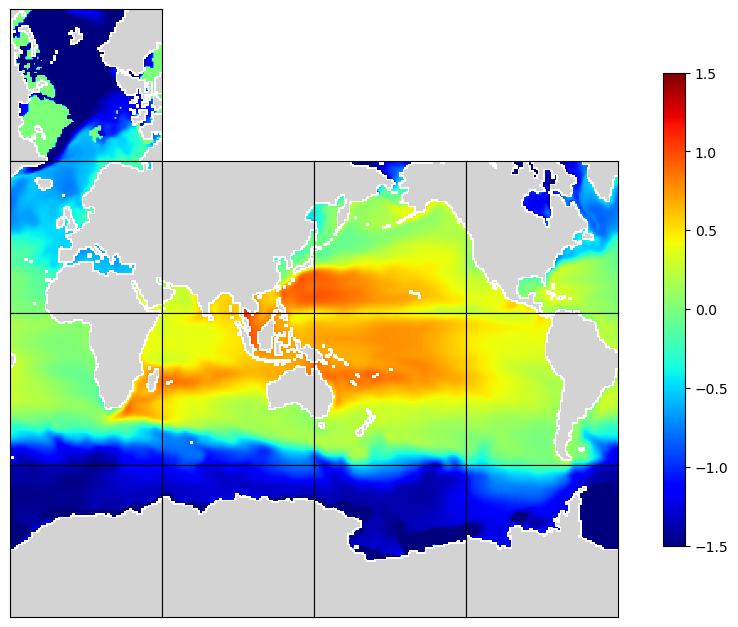

In [41]:
ecco.plot_tiles(ds.ETAN.isel(time=0), mask, layout='latlon', 
                rotate_to_latlon=True, 
                show_tile_labels=False, 
                show_colorbar=True, 
                cmap='jet',
                cmin=-1.5,cmax=1.5)

In [90]:
import utide

In [ ]:
'''epoch : {string, `datetime.date`, `datetime.datetime`}, if datenum is provided in t.
        Default `None` if `t` is `datetime`, `np.datetime64`, or `pd.datetime array.`
        Optional valid strings are
            - 'python' : if `t` is days since '0000-12-31'
            - 'matlab' : if `t` is days since '0000-00-00'
        Or, an arbitrary date in the form 'YYYY-MM-DD'.'''

In [120]:
origin = np.datetime64("2000-01-01T00:00:00")  # <-- Replace with your actual reference time

# Add origin to time to get datetime64
ds_eta_tides["time"] = origin + ds_eta_tides["time"]

In [91]:
from utide import solve, reconstruct

In [121]:
ds_eta_tides.time

<xarray.DataArray 'time' (time: 2160)> Size: 17kB
array(['2000-01-01T00:00:02.000000000', '2000-01-01T00:00:03.000000000',
       '2000-01-01T00:00:04.000000000', ..., '2000-01-01T00:35:59.000000000',
       '2000-01-01T00:36:00.000000000', '2000-01-01T00:36:01.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 17kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 17kB 2000-01-01T00:00:02 ... 2000-01-01T00...
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
    calendar:       gregorian

In [112]:
ds_eta_tides.isel(face=8, i=0, j=0).YC.values

array(9.482398, dtype=float32)

In [122]:
coef = solve(
    ds_eta_tides.time.values,
    ds_eta_tides.ETAN.isel(face=8, i=0, j=0).values,
    lat=9.5,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=0.95,
)

solve: matrix prep ... solution ... done.


In [123]:
tide = utide.reconstruct(ds_eta_tides.time.values, coef, verbose=False)

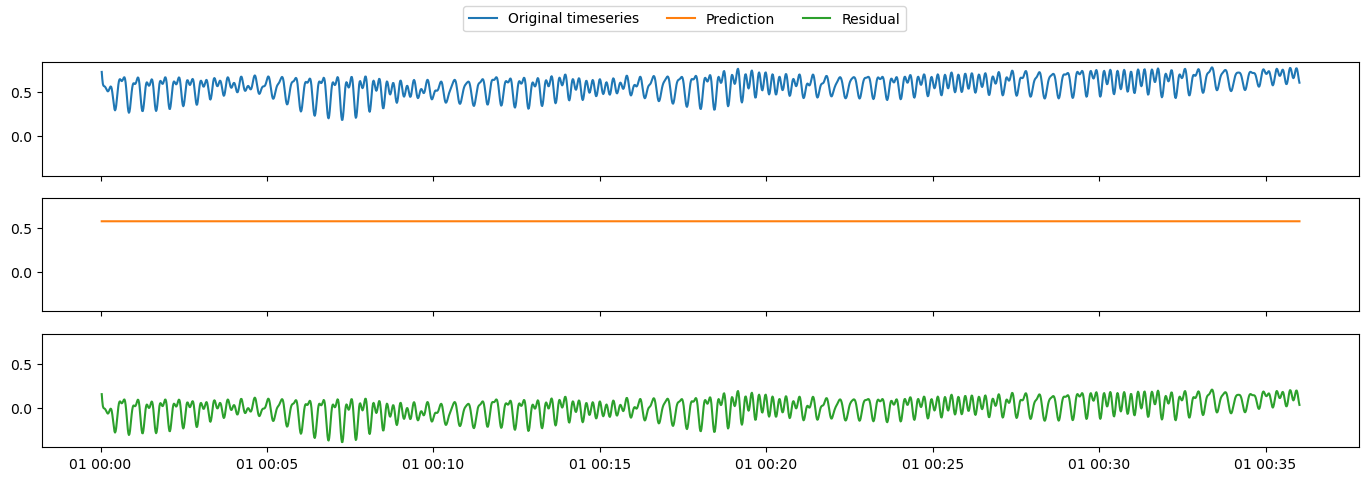

In [124]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(ds_eta_tides.time.values, ds_eta_tides.ETAN.isel(face=8, i=0, j=0).values, label="Original timeseries", color="C0")
ax1.plot(ds_eta_tides.time.values, tide.h, label="Prediction", color="C1")
ax2.plot(ds_eta_tides.time.values, ds_eta_tides.ETAN.isel(face=8, i=0, j=0).values - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center")